In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv("C:/Users/shubh/Desktop/Capstone-2/Final project/Dataset/Store_Weekly_Sales.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

In [9]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month_name()
df['Weekday'] = df['Date'].dt.weekday

In [10]:
weekday = {0:"Monday",1:"Tuesday",2:"Wednesday",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"}
df['Week_Name'] = df['Weekday'].replace(weekday)

In [11]:
df['Store_Name'] = df['Store'].apply(lambda x: f"Store_{x}")

In [12]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Weekday,Week_Name,Store_Name
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,2010,May,6,Sunday,Store_1
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,2010,December,3,Thursday,Store_1
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,February,4,Friday,Store_1
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,February,4,Friday,Store_1
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,2010,May,0,Monday,Store_1


In [13]:
df.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
Year                     int64
Month                   object
Weekday                  int64
Week_Name               object
Store_Name              object
dtype: object

In [14]:
df_pivot = round(pd.pivot_table(data=df,values="Weekly_Sales",columns="Year",index="Month",aggfunc='sum')).reset_index()
df_pivot.head()

Year,Month,2010,2011,2012
0,April,183811789.0,278969312.0,182542788.0
1,August,184538086.0,188081027.0,191612587.0
2,December,323571609.0,229375968.0,46128514.0
3,February,191586881.0,187609204.0,142829598.0
4,January,42239876.0,211965690.0,172220699.0


In [15]:
import pickle

with open("./models/sales_year_pivot.pkl", "wb") as file:
    pickle.dump(df_pivot,file)

### EDA

### Weekly Sales Plot

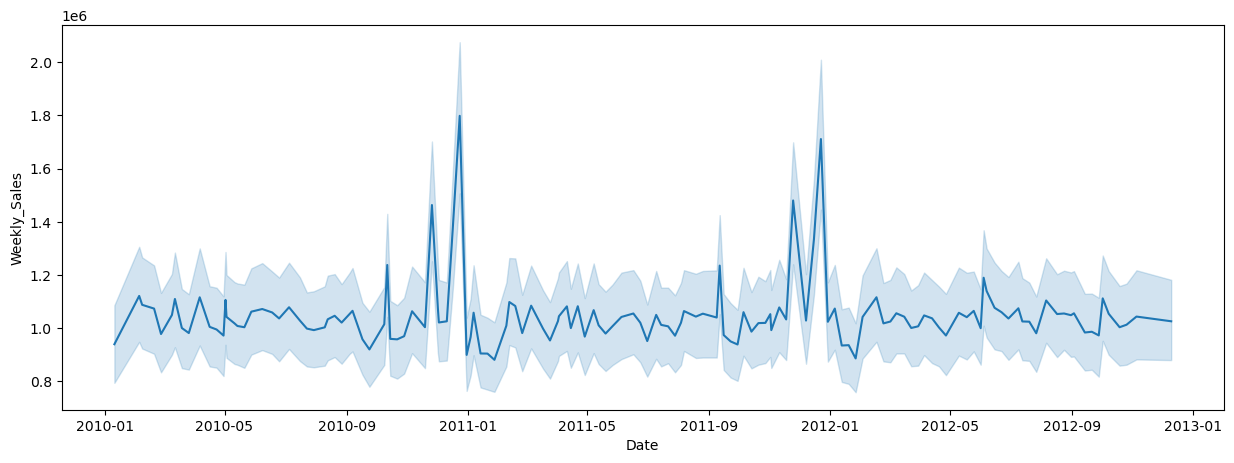

In [15]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df,x="Date",y="Weekly_Sales")
plt.show()

### How is the yearly sales and what is its trend

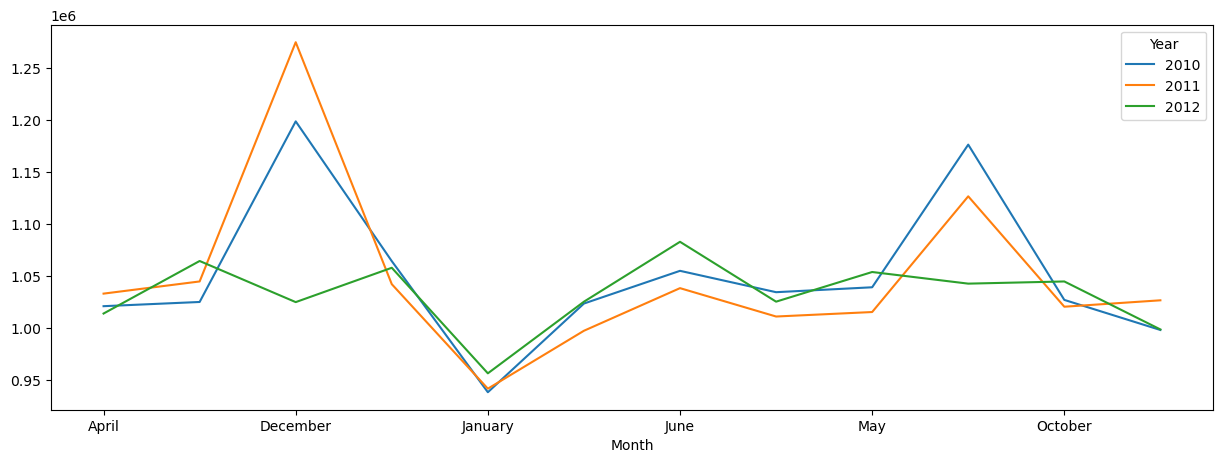

In [17]:
monthly_sales = pd.pivot_table(df, index = "Month", columns = "Year", values = "Weekly_Sales")
monthly_sales.plot(figsize=(15,5))
plt.show()

### Were there higher number of transactions happening in holiday weeks or Non-holiday weeks?

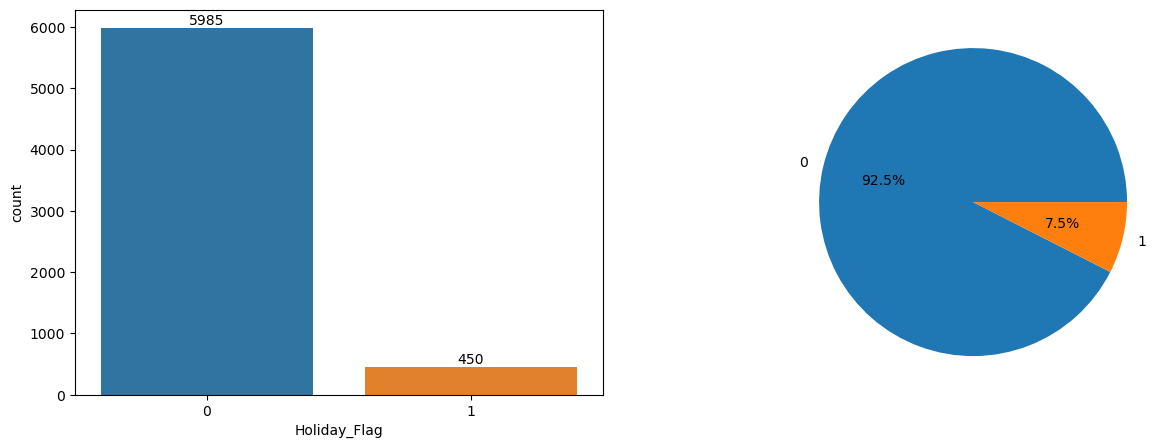

In [18]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax = sns.countplot(data=df,x='Holiday_Flag')
ax.bar_label(ax.containers[0])

plt.subplot(1,2,2)
plt.pie(x = df.groupby('Holiday_Flag').agg({'Weekly_Sales':'sum'})['Weekly_Sales'], 
        labels=df['Holiday_Flag'].unique(),autopct="%1.1f%%")

plt.show()

### Which year had the most number of transactions

In [19]:
df_year = df.groupby('Year').agg({'Weekly_Sales':'sum'}).reset_index()

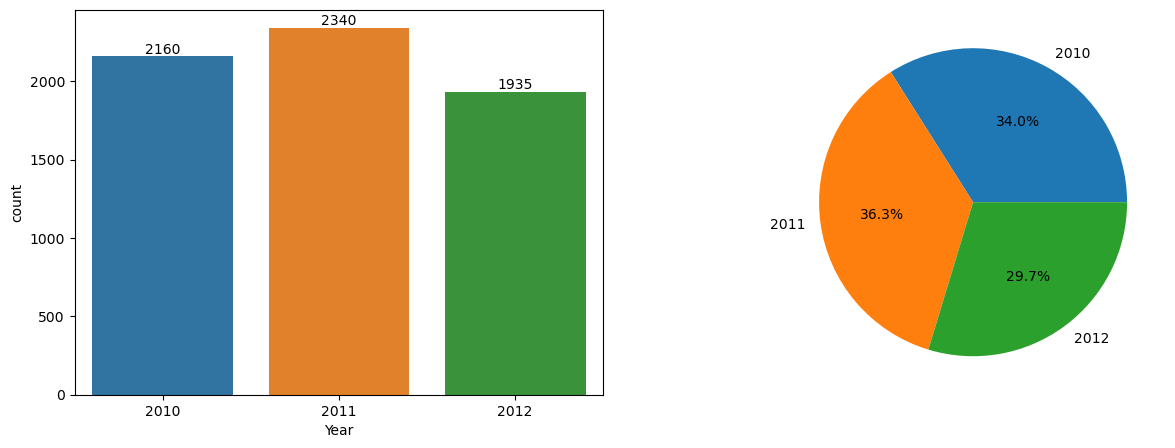

In [20]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax = sns.countplot(data=df,x='Year')
ax.bar_label(ax.containers[0])

plt.subplot(1,2,2)
plt.pie(x = df_year['Weekly_Sales'], labels=df_year['Year'],autopct="%1.1f%%")

plt.show()

### Which month had the highest number of transactions

In [21]:
df_month = df.groupby('Month').agg({'Weekly_Sales':'sum'}).reset_index()

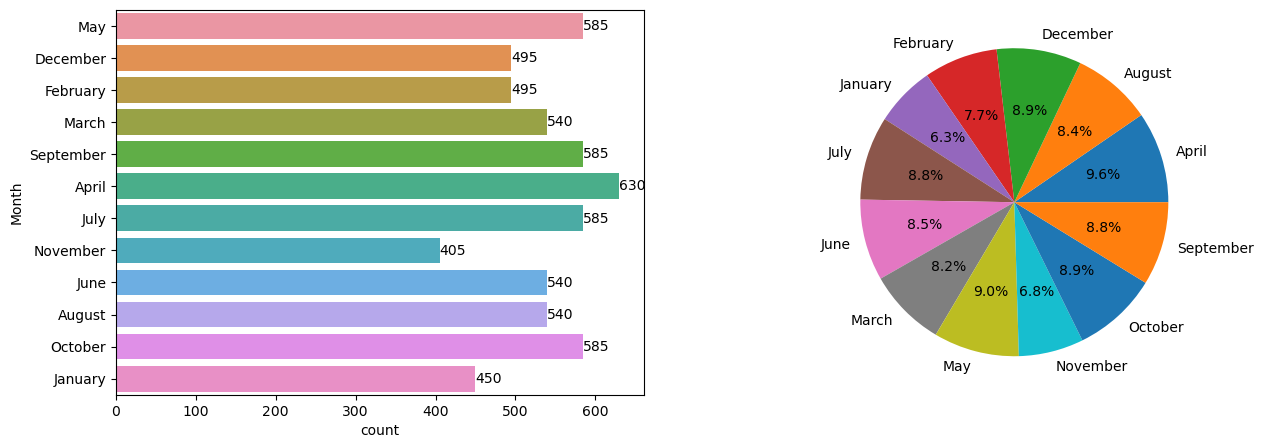

In [22]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax = sns.countplot(data=df,y='Month')
ax.bar_label(ax.containers[0])

plt.subplot(1,2,2)
plt.pie(x = df_month['Weekly_Sales'], labels=df_month['Month'],autopct="%1.1f%%")

plt.show()

### Which week had the most number of transactions

In [23]:
df_week = df.groupby('Week_Name').agg({'Weekly_Sales':'sum'}).reset_index()

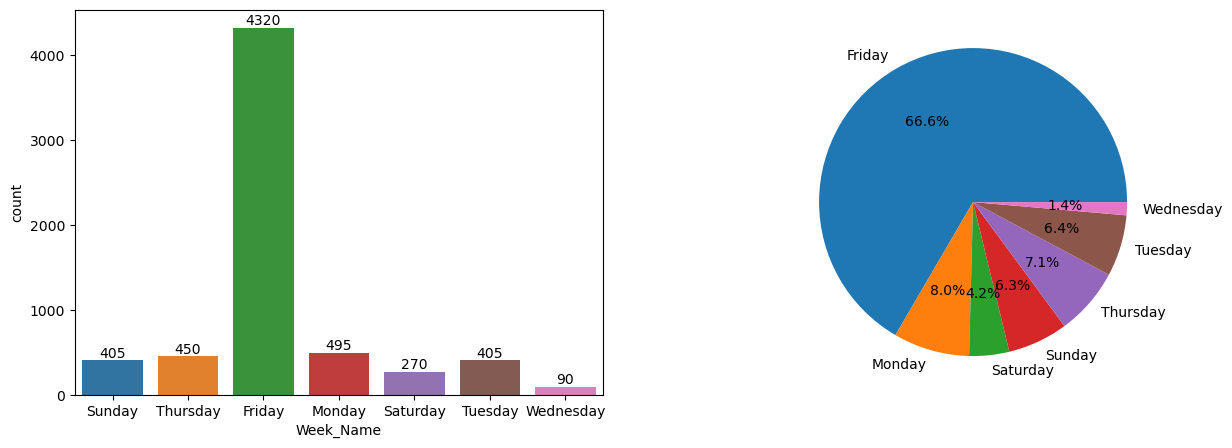

In [24]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax = sns.countplot(data=df,x='Week_Name')
ax.bar_label(ax.containers[0])

plt.subplot(1,2,2)
plt.pie(x = df_week['Weekly_Sales'], labels=df_week['Week_Name'],autopct="%1.1f%%")

plt.show()

### Which store had the highest number of transactions among the walmart stores

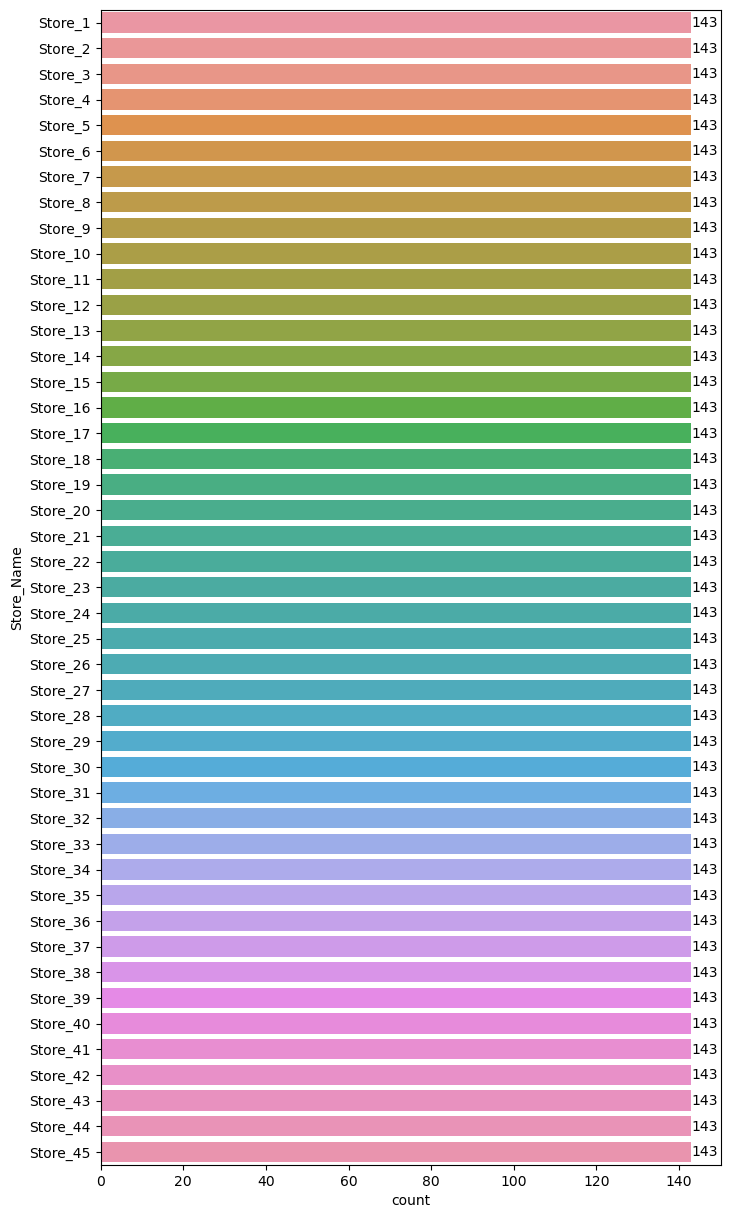

In [25]:
plt.figure(figsize=(8,15))

ax = sns.countplot(data=df,y='Store_Name')
ax.bar_label(ax.containers[0])
plt.show()

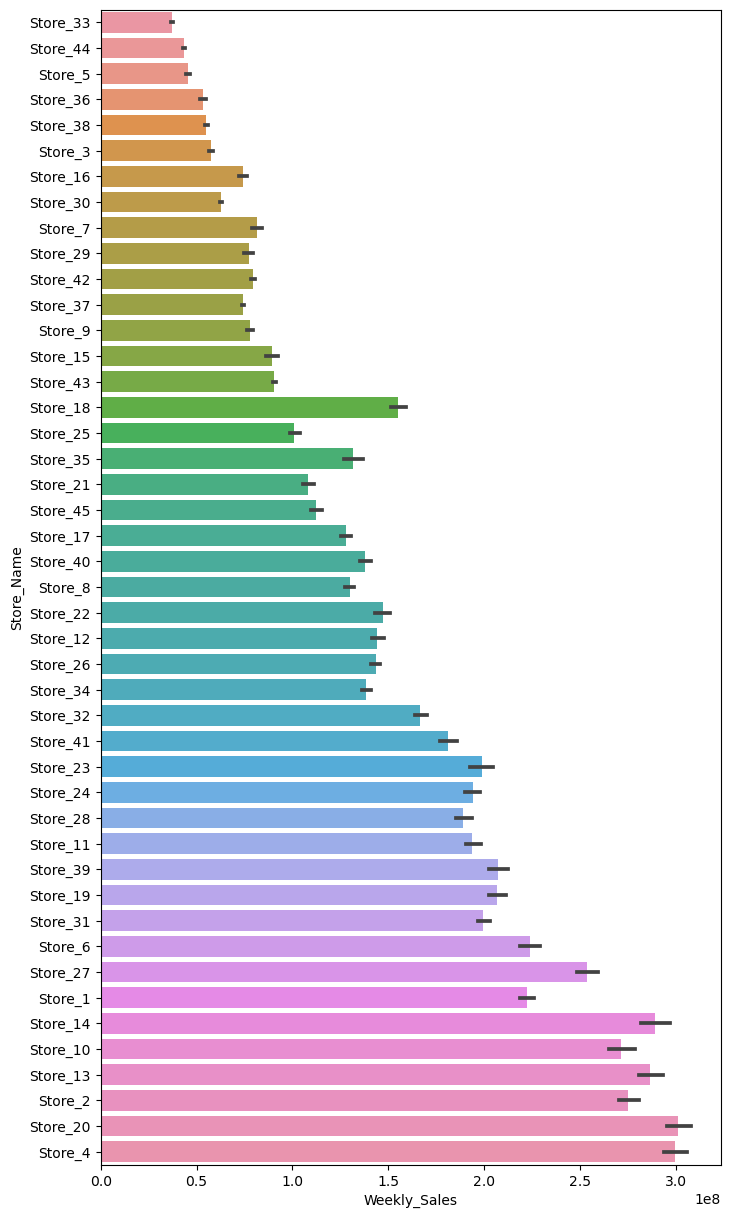

In [33]:
plt.figure(figsize=(8,15))

sns.barplot(data=df.sort_values('Weekly_Sales'),
            y='Store_Name',x='Weekly_Sales',estimator='sum')
plt.show()

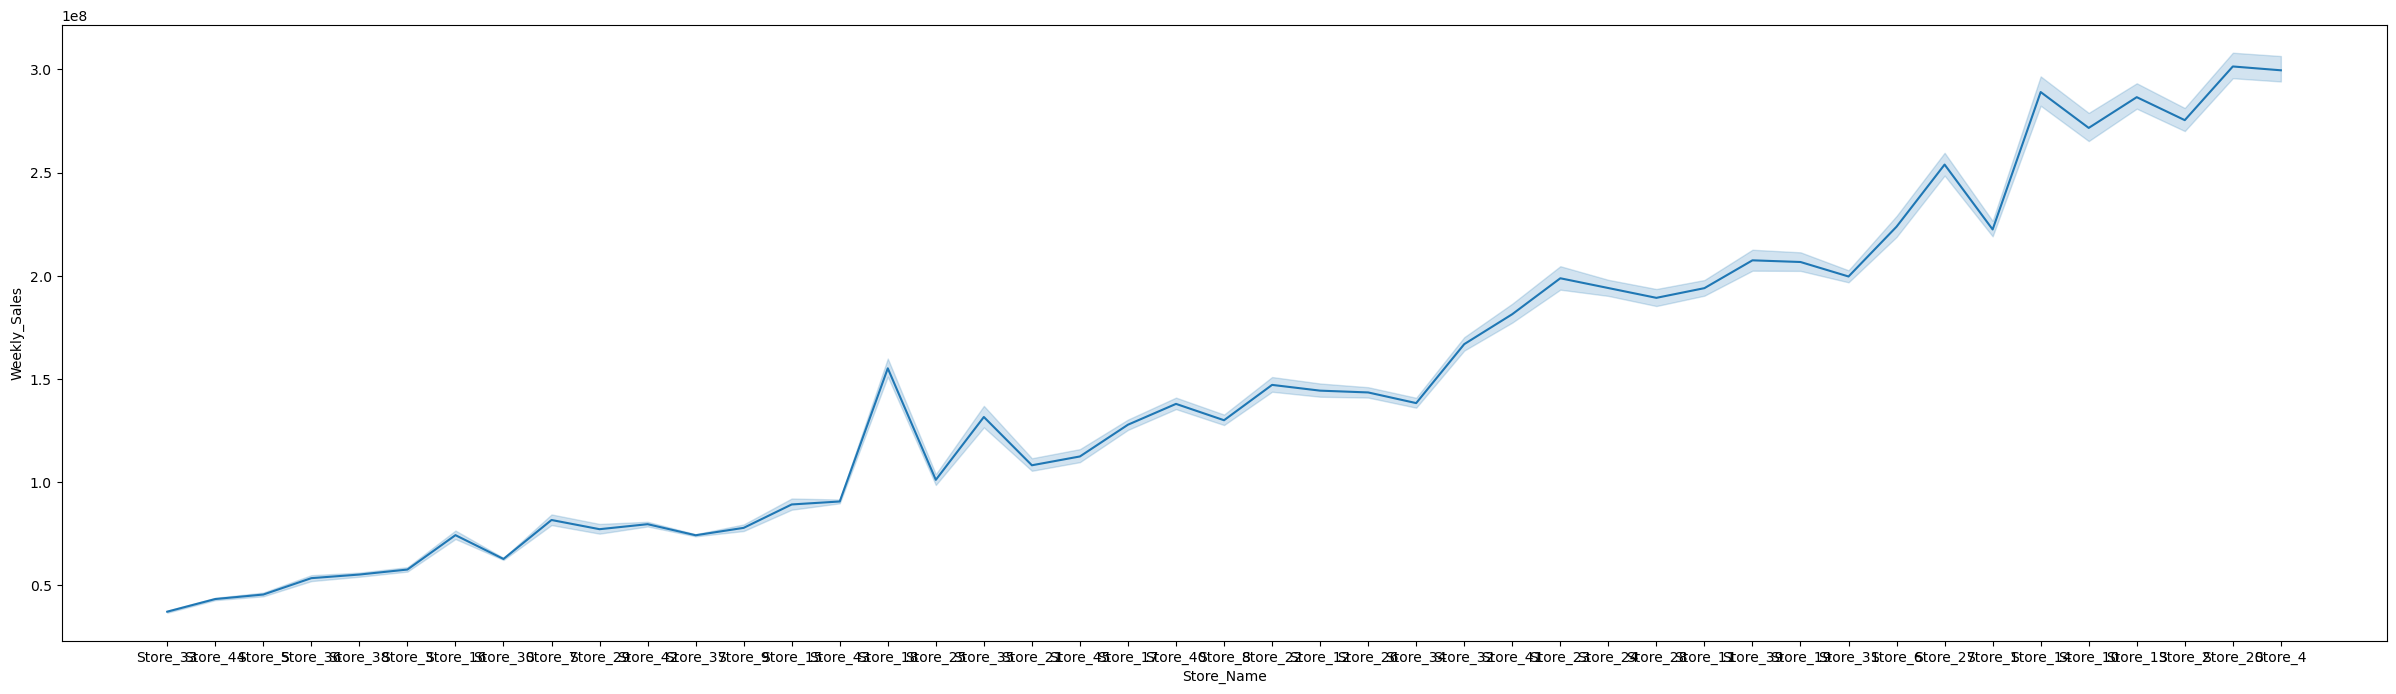

In [32]:
plt.figure(figsize=(30,8))

sns.lineplot(data=df.sort_values('Weekly_Sales'),
            x='Store_Name',y='Weekly_Sales',estimator='sum')
plt.show()

### Which Store has the highest and lowest sales among Walmart

In [34]:
store_sales = df.groupby('Store_Name').agg({'Weekly_Sales':'sum'}).reset_index()
store_sales['Rank'] = store_sales['Weekly_Sales'].rank(ascending=False)

store_sales[(store_sales['Rank'] <=5) | (store_sales['Rank'] >= 41)].sort_values('Rank',ascending=True)

,Store_Name,Weekly_Sales,Rank
12,Store_20,3.013978e+08,1.0
33,Store_4,2.995440e+08,2.0
5,Store_14,2.889999e+08,3.0
4,Store_13,2.865177e+08,4.0
11,Store_2,2.753824e+08,5.0
31,Store_38,5.515963e+07,41.0
29,Store_36,5.341221e+07,42.0
40,Store_5,4.547569e+07,43.0
38,Store_44,4.329309e+07,44.0
26,Store_33,3.716022e+07,45.0


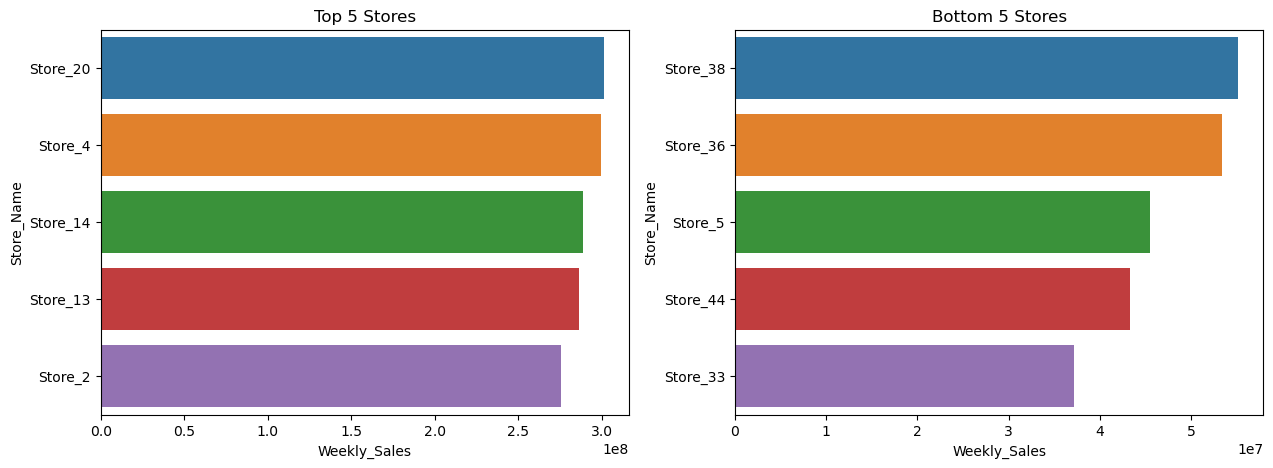

In [35]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=store_sales[store_sales['Rank'] <=5].sort_values('Rank'),
            y='Store_Name',x='Weekly_Sales',estimator='sum')
plt.title("Top 5 Stores")

plt.subplot(1,2,2)
sns.barplot(data=store_sales[store_sales['Rank'] >=41].sort_values('Rank'),
            y='Store_Name',x='Weekly_Sales',estimator='sum')
plt.title("Bottom 5 Stores")


plt.show()

### Which store performed well and performed least during the holiday week

In [36]:
stores_sales_holiday = df[df['Holiday_Flag'] == 1].groupby('Store_Name').agg({
    'Weekly_Sales':
    'sum'
}).reset_index()

stores_sales_holiday['Rank'] = stores_sales_holiday['Weekly_Sales'].rank(
    ascending=False)

stores_sales_holiday[(stores_sales_holiday['Rank'] <= 5) |
                     (stores_sales_holiday['Rank'] >= 41)].sort_values(
                         'Rank', ascending=True)

,Store_Name,Weekly_Sales,Rank
12,Store_20,22490350.81,1.0
33,Store_4,22431026.24,2.0
5,Store_14,21205829.98,3.0
1,Store_10,21137559.49,4.0
4,Store_13,21130438.06,5.0
31,Store_38,3815098.78,41.0
29,Store_36,3676406.30,42.0
40,Store_5,3595016.07,43.0
38,Store_44,2960356.01,44.0
26,Store_33,2625945.19,45.0


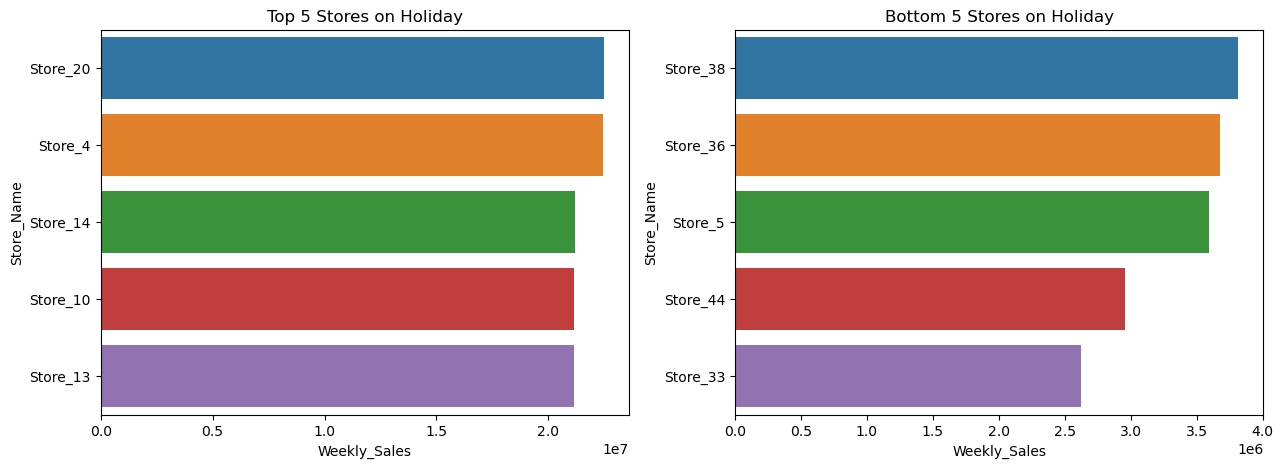

In [37]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=stores_sales_holiday[stores_sales_holiday['Rank'] <=5].sort_values('Rank'),
            y='Store_Name',x='Weekly_Sales',estimator='sum')
plt.title("Top 5 Stores on Holiday")

plt.subplot(1,2,2)
sns.barplot(data=stores_sales_holiday[stores_sales_holiday['Rank'] >=41].sort_values('Rank'),
            y='Store_Name',x='Weekly_Sales',estimator='sum')
plt.title("Bottom 5 Stores on Holiday")


plt.show()

### Which store had the highest and least sales in each year

In [38]:
store_sales_yearwise = df.groupby(['Year','Store_Name']).agg({'Weekly_Sales':'sum'}).reset_index()

store_sales_yearwise['rank'] = store_sales_yearwise.groupby('Year')['Weekly_Sales'].rank(ascending=False)

top_performer = store_sales_yearwise[store_sales_yearwise['rank'] <= 5]
bottom_performer = store_sales_yearwise[store_sales_yearwise['rank'] >= 41]

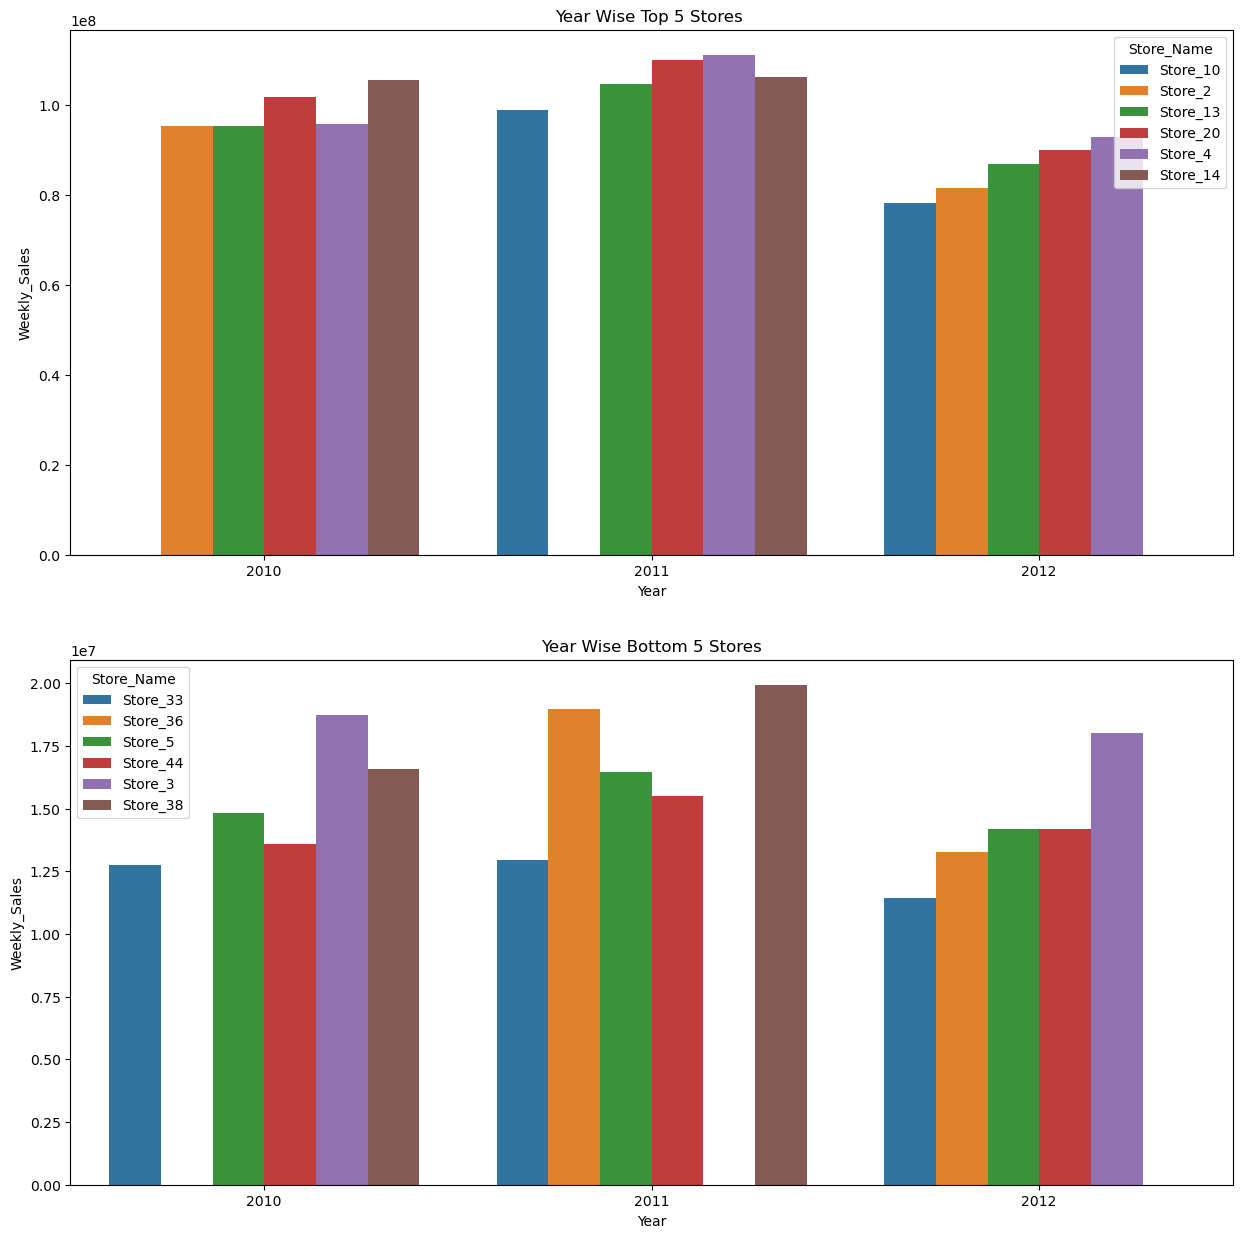

In [39]:
plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
sns.barplot(data=top_performer.sort_values(['Year','rank'],ascending=False),
            x='Year',y='Weekly_Sales',estimator='sum',hue='Store_Name')
plt.title("Year Wise Top 5 Stores ")

plt.subplot(2,1,2)
sns.barplot(data=bottom_performer.sort_values(['Year','rank'],ascending=False),
            x='Year',y='Weekly_Sales',estimator='sum',hue='Store_Name')
plt.title("Year Wise Bottom 5 Stores")


plt.show()

### Scatter Plot to Check Relation Between Numerical Variables

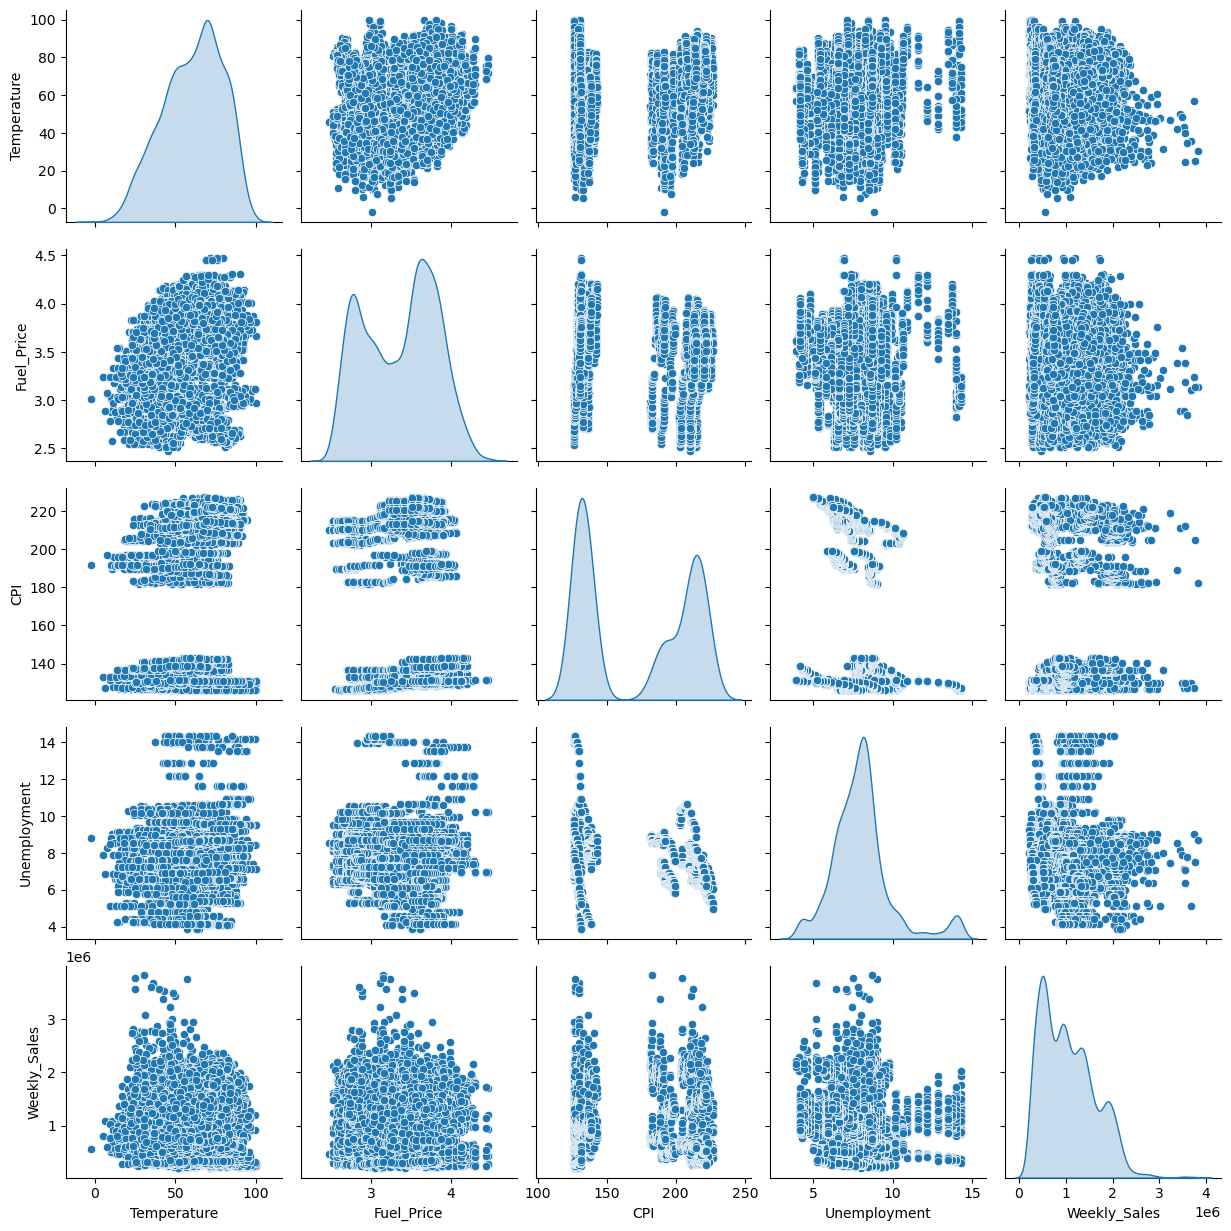

In [40]:
cols = ['Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales']

sns.pairplot(df[cols],diag_kind='kde')
plt.show()

### Correlation between numerical Features

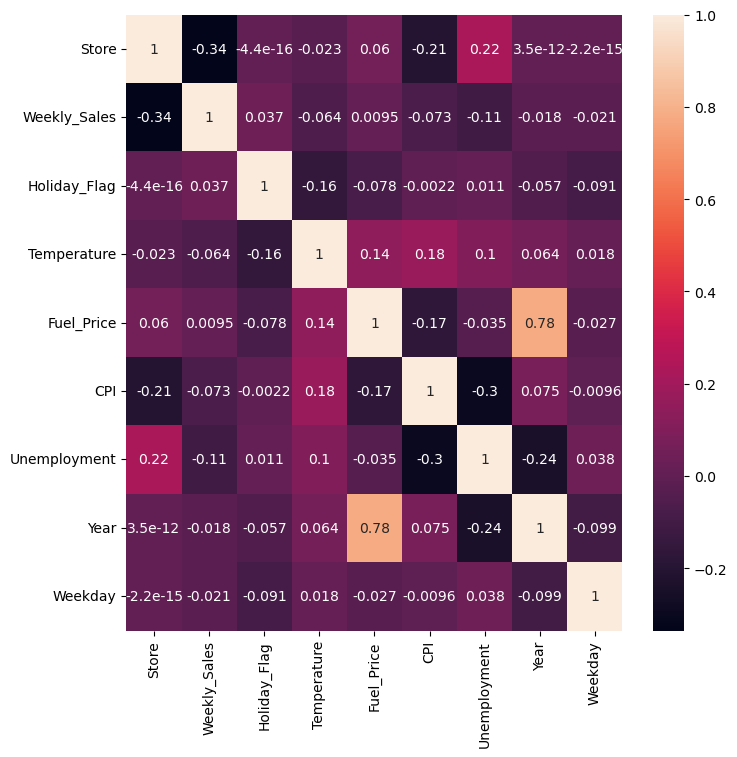

In [41]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),annot=True)
plt.show()

### Outlier Treatment

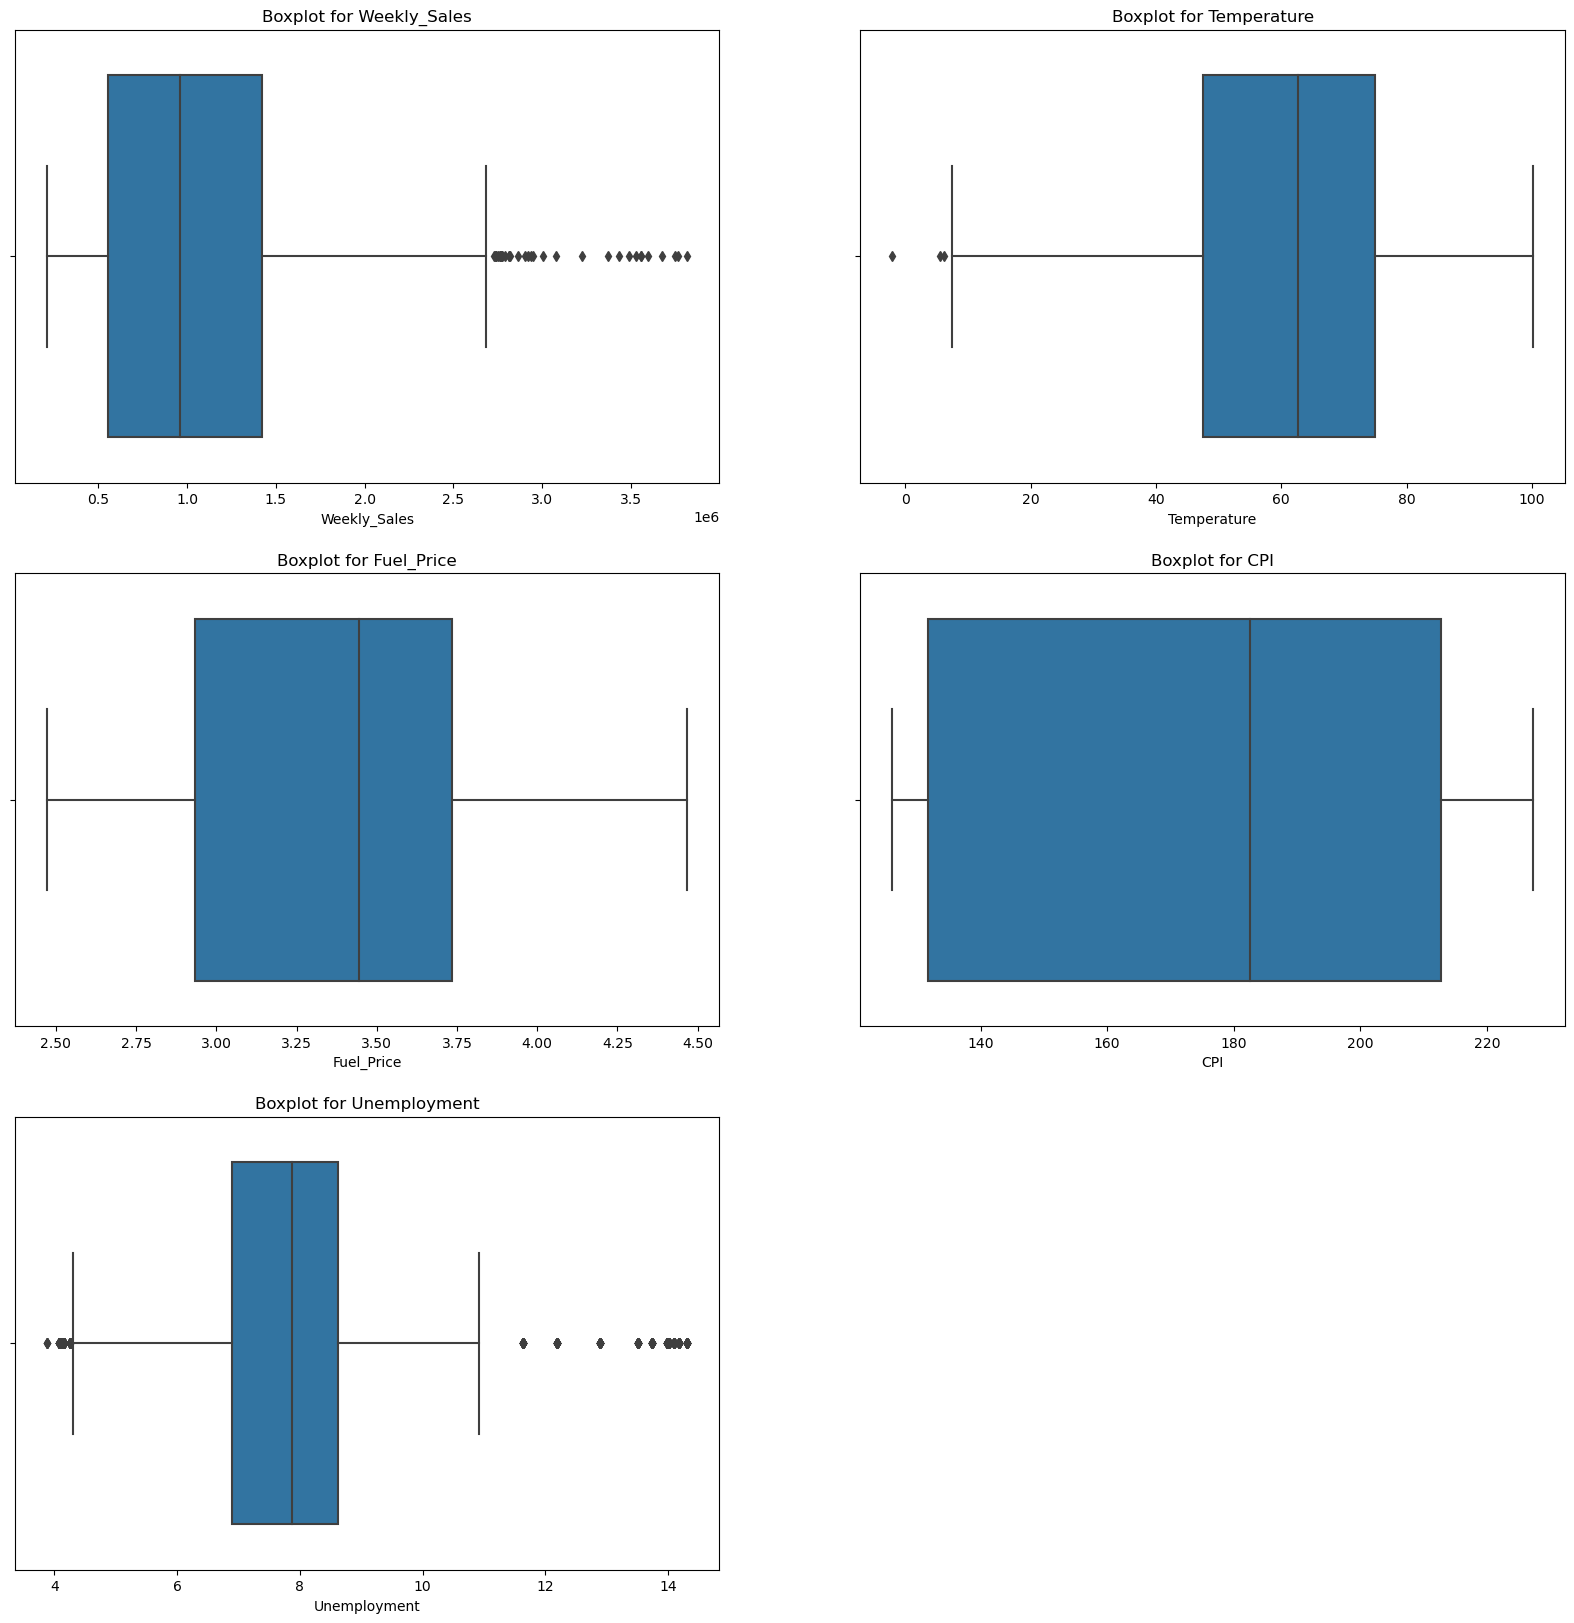

In [42]:
num_cols = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment']

plt.figure(figsize=(20,20))

for i in range(len(num_cols)):
    plt.subplot(3,2,i+1)
    sns.boxplot(data = df,x = num_cols[i])
    plt.title(f"Boxplot for {num_cols[i]}")
plt.show()

In [43]:
df[num_cols].describe(percentiles=[0.01,0.02,0.05,0.95,0.97,0.98,0.99])

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
count,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.046965e+06,60.663782,3.358607,171.578394,7.999151
std,5.643666e+05,18.444933,0.459020,39.356712,1.875885
min,2.099862e+05,-2.060000,2.472000,126.064000,3.879000
1%,2.531031e+05,18.523600,2.565000,126.106903,4.156000
2%,2.752586e+05,21.867200,2.582000,126.136065,4.420000
5%,3.084267e+05,27.730000,2.642000,126.491290,5.326000
50%,9.607460e+05,62.670000,3.445000,182.616521,7.874000
95%,2.049179e+06,87.663000,4.029000,221.926729,12.187000
97%,2.135966e+06,89.849600,4.110000,223.381181,13.736000


### IQR Method for Outlier Treatment

In [44]:
df.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
Year                     int64
Month                   object
Weekday                  int64
Week_Name               object
Store_Name              object
dtype: object

In [45]:
df['Weekly_Sales'] = np.where(df['Weekly_Sales']>df['Weekly_Sales'].quantile(0.99),
                                 df['Weekly_Sales'].quantile(0.99),
                                 df['Weekly_Sales'])

df['Unemployment'] = np.where(df['Unemployment']>df['Unemployment'].quantile(0.97),
                                 df['Unemployment'].quantile(0.97),
                                 df['Unemployment'])

df['Unemployment'] = np.where(df['Unemployment']<df['Unemployment'].quantile(0.01),
                                 df['Unemployment'].quantile(0.01),
                                 df['Unemployment'])

df['Temperature'] = np.where(df['Temperature']<df['Temperature'].quantile(0.01),
                                 df['Temperature'].quantile(0.01),
                                 df['Temperature'])

In [46]:
df[num_cols].describe(percentiles=[0.01,0.02,0.05,0.95,0.97,0.98,0.99])

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
count,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.042743e+06,60.706265,3.358607,171.578394,7.988479
std,5.511055e+05,18.338877,0.459020,39.356712,1.839142
min,2.099862e+05,18.523600,2.472000,126.064000,4.156000
1%,2.531031e+05,18.532576,2.565000,126.106903,4.156000
2%,2.752586e+05,21.867200,2.582000,126.136065,4.420000
5%,3.084267e+05,27.730000,2.642000,126.491290,5.326000
50%,9.607460e+05,62.670000,3.445000,182.616521,7.874000
95%,2.049179e+06,87.663000,4.029000,221.926729,12.187000
97%,2.135966e+06,89.849600,4.110000,223.381181,13.736000


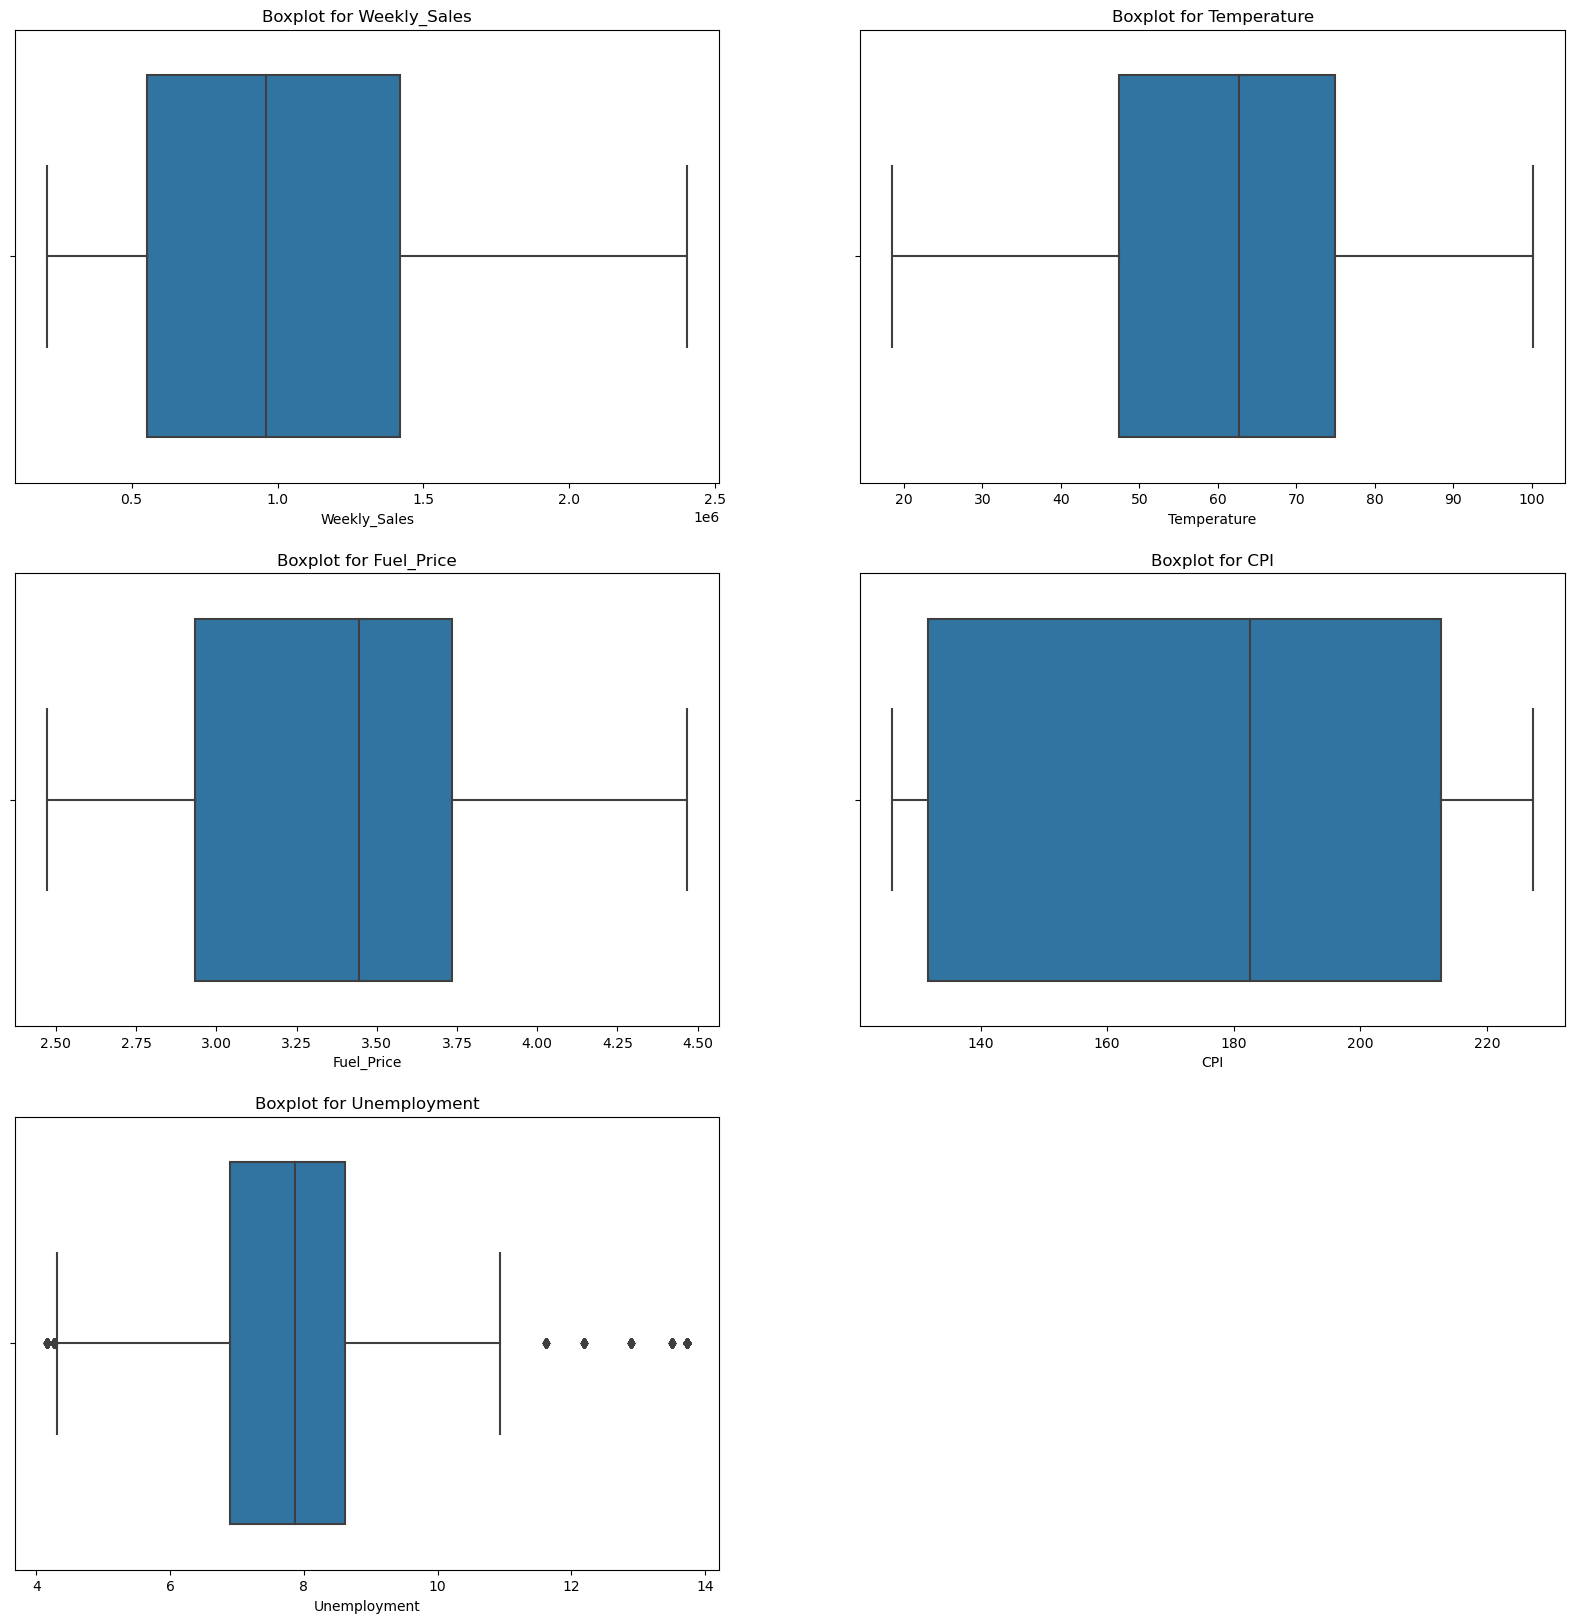

In [47]:
num_cols = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment']

plt.figure(figsize=(20,20))

for i in range(len(num_cols)):
    plt.subplot(3,2,i+1)
    sns.boxplot(data = df,x = num_cols[i])
    plt.title(f"Boxplot for {num_cols[i]}")
plt.show()

In [48]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Weekday,Week_Name,Store_Name
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,2010,May,6,Sunday,Store_1
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,2010,December,3,Thursday,Store_1
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,February,4,Friday,Store_1
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,February,4,Friday,Store_1
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,2010,May,0,Monday,Store_1


### Select x and Y

In [49]:
x = df.drop(['Weekly_Sales','Date','Year','Month','Weekday','Week_Name','Store_Name'],axis=1)
y = df['Weekly_Sales']
print(x.shape)
print(y.shape)

(6435, 6)
(6435,)


In [50]:
x.head()

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,0,42.31,2.572,211.096358,8.106
1,1,1,38.51,2.548,211.242170,8.106
2,1,0,39.93,2.514,211.289143,8.106
3,1,0,46.63,2.561,211.319643,8.106
4,1,0,46.50,2.625,211.350143,8.106


In [51]:
y.head()

0    1643690.90
1    1641957.44
2    1611968.17
3    1409727.59
4    1554806.68
Name: Weekly_Sales, dtype: float64

### Check Multicollinearity(VIF)

In [52]:
vif = pd.DataFrame()
vif['Feature'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif = vif.sort_values('VIF',ascending=False)
vif

,Feature,VIF
3,Fuel_Price,26.958428
5,Unemployment,16.814685
4,CPI,14.814661
2,Temperature,13.518362
0,Store,4.410827
1,Holiday_Flag,1.099914


In [53]:
x.drop('Fuel_Price',axis=1,inplace=True)

In [54]:
vif1 = pd.DataFrame()
vif1['Feature'] = x.columns
vif1['VIF'] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif1 = vif1.sort_values('VIF',ascending=False)
vif1

,Feature,VIF
4,Unemployment,13.073419
2,Temperature,12.411180
3,CPI,11.434337
0,Store,4.238183
1,Holiday_Flag,1.099691


### Check Target Variable Normality

In [55]:
from scipy.stats import shapiro, jarque_bera
# Ho : Data is normally dist => p>0.05
# H1 : Data is not normally dist => p<=0.05

In [56]:
def normality_check(x):
    test_stat,p_val = shapiro(x)
    print("P-Value :",p_val)
    if p_val > 0.05:
        print("Data is normally distributed")
    else:
        print("Data is not normally distributed")
    sns.histplot(x,kde=True)
    plt.show()

P-Value : 1.2163270670339412e-42
Data is not normally distributed


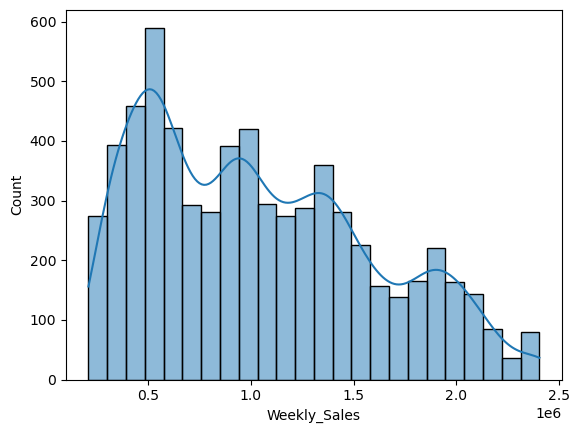

In [58]:
normality_check(df['Weekly_Sales'])

P-Value : 9.755741257217488e-37
Data is not normally distributed


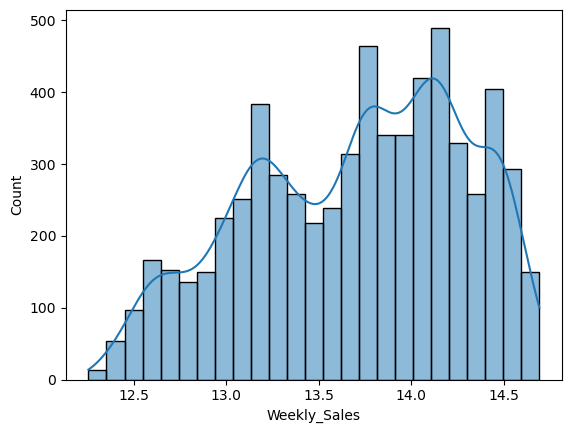

In [59]:
normality_check(np.log(df['Weekly_Sales']))

P-Value : 3.089808574313476e-33
Data is not normally distributed


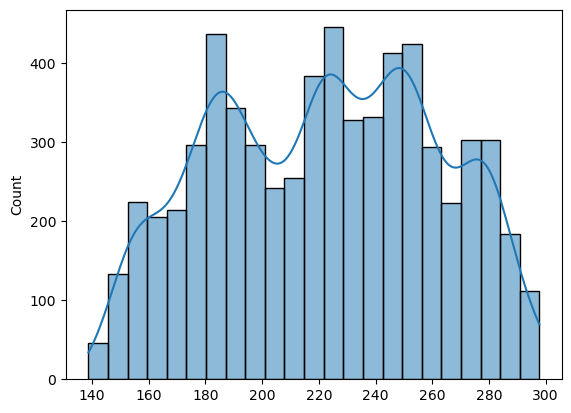

In [60]:
y_transform,param = boxcox(df['Weekly_Sales'])
normality_check(y_transform)

### Train-Test Split

In [61]:
x_train,x_test, y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4826, 5)
(1609, 5)
(4826,)
(1609,)


In [62]:
x_train.columns

Index(['Store', 'Holiday_Flag', 'Temperature', 'CPI', 'Unemployment'], dtype='object')

### Evaluation Metrics

In [63]:
def eval_model(model,x_train,y_train,x_test,y_test,modelname):
    ypred_train = model.predict(x_train)
    ypred_test = model.predict(x_test)
    train_rmse = np.sqrt(mean_squared_error(y_train,ypred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test,ypred_test))
    train_mae = mean_absolute_error(y_train,ypred_train)
    test_mae = mean_absolute_error(y_test,ypred_test)
    Test_acc = model.score(x_test,y_test)
    Train_acc = model.score(x_train,y_train)

    res = pd.DataFrame({'Train_RMSE':round(train_rmse,2),
                        'Test_RMSE':round(test_rmse,2),
                       'Train_MAE':round(train_mae,2),
                       'Test_MAE':round(test_mae,2),
                        'Train_Acc':Train_acc,
                       'Test_Acc':Test_acc},index=[modelname])
    return ypred_test, res

### Standardize Dataset

In [64]:
sc = StandardScaler()
sc.fit(x_train)

StandardScaler()

In [65]:
x_train_trf = pd.DataFrame(sc.transform(x_train),columns = x_train.columns)
x_train_trf.head()

,Store,Holiday_Flag,Temperature,CPI,Unemployment
0,1.600472,-0.268712,-1.777075,-1.061606,-1.044199
1,0.291601,-0.268712,0.309594,-0.735573,0.134952
2,-1.325239,3.721455,0.128477,1.237749,-0.786106
3,-0.786293,-0.268712,-0.922768,-1.063975,-0.872864
4,1.446487,-0.268712,0.444341,-1.063975,-0.064211


In [66]:
x_test_trf = pd.DataFrame(sc.transform(x_test),columns = x_test.columns)
x_test_trf.head()

,Store,Holiday_Flag,Temperature,CPI,Unemployment
0,-0.401330,-0.268712,-0.983868,-1.013500,0.660413
1,0.060624,-0.268712,0.461253,-0.924701,0.120219
2,-1.633209,-0.268712,0.297047,1.168456,-0.300477
3,0.214609,-0.268712,-1.109886,-0.894180,-0.214810
4,0.984533,-0.268712,-0.047185,0.981106,0.306832


### Linear Regression

In [67]:
y_train_boxcox,param_train = boxcox(y_train)
y_test_boxcox,param_test = boxcox(y_test)

In [68]:
def eval_model_lr(model,x_train,y_train,x_test,y_test,modelname,param_train,param_test):
    ypred_train =inv_boxcox(model.predict(x_train),param_train)
    ypred_test = inv_boxcox(model.predict(x_test),param_test)
    train_rmse = np.sqrt(mean_squared_error(y_train,ypred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test,ypred_test))
    train_mae = mean_absolute_error(y_train,ypred_train)
    test_mae = mean_absolute_error(y_test,ypred_test)
    Test_acc = model.score(x_test,y_test)
    Train_acc = model.score(x_train,y_train)

    res = pd.DataFrame({'Train_RMSE':round(train_rmse,2),
                        'Test_RMSE':round(test_rmse,2),
                       'Train_MAE':round(train_mae,2),
                       'Test_MAE':round(test_mae,2),
                        'Train_Acc':Train_acc,
                       'Test_Acc':Test_acc},index=[modelname])
    return ypred_test, res

In [69]:
lr1 = LinearRegression()
lr1.fit(x_train,y_train_boxcox)

LinearRegression()

In [70]:
ypred_lr1, lr1_res = eval_model_lr(lr1,x_train,y_train_boxcox,x_test,
                                 y_test_boxcox,'Lin_Reg_boxcox',param_train,param_test)
lr1_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
Lin_Reg_boxcox,960696.47,87106.24,943541.18,86178.4,0.119807,-7.899099


In [71]:
lr2 = LinearRegression()
lr2.fit(x_train_trf,y_train)

LinearRegression()

In [72]:
ypred_lr2, lr2_res = eval_model(lr2,x_train_trf,y_train,x_test_trf,y_test,'Lin_Reg_SC')
lr2_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
Lin_Reg_SC,510356.13,510456.64,424890.12,428015.98,0.139493,0.14938


In [73]:
lr3 = LinearRegression()
lr3.fit(x_train,y_train)

LinearRegression()

In [74]:
ypred_lr3, lr3_res = eval_model(lr3,x_train,y_train,x_test,y_test,'Lin_Reg')
lr3_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
Lin_Reg,510356.13,510456.64,424890.12,428015.98,0.139493,0.14938


### Decision Tree

In [75]:
dt = DecisionTreeRegressor()
dt.fit(x_train,y_train)

DecisionTreeRegressor()

In [76]:
ypred_dt, dt_res = eval_model(dt,x_train,y_train,x_test,y_test,'DT_Reg')
dt_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
DT_Reg,0.0,169261.67,0.0,93848.61,1.0,0.906473


In [77]:
dt1 = DecisionTreeRegressor()
dt1.fit(x_train_trf,y_train)

DecisionTreeRegressor()

In [78]:
ypred_dt1, dt1_res = eval_model(dt1,x_train_trf,y_train,x_test_trf,y_test,'DT_Reg_SC')
dt1_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
DT_Reg_SC,0.0,173564.88,0.0,96088.82,1.0,0.901657


### Random Forest

In [79]:
rf = RandomForestRegressor()
rf.fit(x_train,y_train)

RandomForestRegressor()

In [80]:
ypred_rf, rf_res = eval_model(rf,x_train,y_train,x_test,y_test,'RF_Reg')
rf_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
RF_Reg,46737.3,128875.12,26506.72,73645.81,0.992783,0.94578


In [81]:
rf1 = RandomForestRegressor()
rf1.fit(x_train_trf,y_train)

RandomForestRegressor()

In [82]:
ypred_rf1, rf1_res = eval_model(rf1,x_train_trf,y_train,x_test_trf,y_test,'RF_Reg_SC')
rf1_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
RF_Reg_SC,45937.9,126944.98,26279.96,72743.99,0.993028,0.947392


### K-Nearest Neighbour

In [83]:
knn = KNeighborsRegressor()
knn.fit(x_train_trf,y_train)

KNeighborsRegressor()

In [84]:
ypred_knn, knn_res = eval_model(knn,x_train_trf,y_train,x_test_trf,y_test,'KNN_Reg_SC')
knn_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
KNN_Reg_SC,213332.85,284982.08,125443.86,170642.67,0.849643,0.734874


In [85]:
knn1 = KNeighborsRegressor()
knn1.fit(x_train,y_train)

KNeighborsRegressor()

In [86]:
ypred_knn1, knn1_res = eval_model(knn1,x_train,y_train,x_test,y_test,'KNN_Reg')
knn1_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
KNN_Reg,222895.91,283774.26,139029.76,185034.55,0.835861,0.737116


### Ada-Boost Regressor

In [87]:
ada = AdaBoostRegressor(n_estimators=1000,random_state=42)
ada.fit(x_train,y_train)

AdaBoostRegressor(n_estimators=1000, random_state=42)

In [88]:
ypred_ada, ada_res = eval_model(ada,x_train,y_train,
                                  x_test,y_test,'AdaBoost_Reg')
ada_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
AdaBoost_Reg,418411.79,413218.52,353934.27,344954.93,0.421617,0.442587


In [89]:
ada1 = AdaBoostRegressor(n_estimators=1000,random_state=42)
ada1.fit(x_train_trf,y_train)

AdaBoostRegressor(n_estimators=1000, random_state=42)

In [90]:
ypred_ada1, ada1_res = eval_model(ada1,x_train_trf,y_train,
                                  x_test_trf,y_test,'AdaBoost_Reg')
ada1_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
AdaBoost_Reg,418411.79,413218.52,353934.27,344954.93,0.421617,0.442587


### Gradient Boost Regressor

In [91]:
gb = GradientBoostingRegressor(n_estimators=100,learning_rate=0.3,
                                max_depth=1,min_samples_split=2,
                                criterion='squared_error',
                                loss='huber', random_state=25)
gb.fit(x_train,y_train)

GradientBoostingRegressor(criterion='squared_error', learning_rate=0.3,
                          loss='huber', max_depth=1, random_state=25)

In [92]:
ypred_gb, gb_res = eval_model(gb,x_train,y_train,
                                  x_test,y_test,'GradBoost_Reg')
gb_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
GradBoost_Reg,398119.69,395834.23,327820.26,325400.37,0.476357,0.488502


In [93]:
gb1 = GradientBoostingRegressor(n_estimators=100,learning_rate=0.3,
                                max_depth=1,min_samples_split=2,
                                criterion='squared_error',
                                loss='huber', random_state=25)
gb1.fit(x_train_trf,y_train)

GradientBoostingRegressor(criterion='squared_error', learning_rate=0.3,
                          loss='huber', max_depth=1, random_state=25)

In [94]:
ypred_gb1, gb1_res = eval_model(gb1,x_train_trf,y_train,
                                  x_test_trf,y_test,'GradBoost_Reg')
gb1_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
GradBoost_Reg,398119.69,395834.23,327820.26,325400.37,0.476357,0.488502


### XG Boost Regressor

In [95]:
xgb = XGBRegressor(objective='reg:squarederror',eval_metric=mean_squared_error,
                     n_estimators=100,random_state=42,gamma=0.2,reg_lambda=0.3)
xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x000001D298E099E0>,
             feature_types=None, gamma=0.2, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [96]:
ypred_xgb, xgb_res = eval_model(xgb,x_train,y_train,
                                  x_test,y_test,'XGBoost_Reg')
xgb_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
XGBoost_Reg,46106.71,113193.65,31884.45,67807.38,0.992977,0.958173


In [97]:
all_res = pd.concat([lr1_res,lr2_res,lr2_res,dt_res,dt1_res,rf_res,rf1_res,
                     knn_res,knn1_res,ada_res,ada1_res,gb_res,gb1_res,xgb_res])
all_res

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
Lin_Reg_boxcox,960696.47,87106.24,943541.18,86178.40,0.119807,-7.899099
Lin_Reg_SC,510356.13,510456.64,424890.12,428015.98,0.139493,0.149380
Lin_Reg_SC,510356.13,510456.64,424890.12,428015.98,0.139493,0.149380
DT_Reg,0.00,169261.67,0.00,93848.61,1.000000,0.906473
DT_Reg_SC,0.00,173564.88,0.00,96088.82,1.000000,0.901657
RF_Reg,46737.30,128875.12,26506.72,73645.81,0.992783,0.945780
RF_Reg_SC,45937.90,126944.98,26279.96,72743.99,0.993028,0.947392
KNN_Reg_SC,213332.85,284982.08,125443.86,170642.67,0.849643,0.734874
KNN_Reg,222895.91,283774.26,139029.76,185034.55,0.835861,0.737116
AdaBoost_Reg,418411.79,413218.52,353934.27,344954.93,0.421617,0.442587


In [98]:
hparams_xgb = {'n_estimators': [70,80,90,100],
              'eta':[0.1,0.2,0.3,0.4,0.5],
              'gamma':[0.1,0.2,0.3,0.4,0.5,5,6,10],
              'max_depth':[5,6,7,8],
              'lambda':[0.1,0.2,0.3,0.4,0.5,5,6,10],
              'alpha':[0.1,0.2,0.3,5,6,10]}

In [99]:
xgb_base = XGBRegressor(objective='reg:squarederror',eval_metric=mean_squared_error)

gs_cv = GridSearchCV(estimator=xgb_base,param_grid=hparams_xgb,
                           scoring='accuracy',cv=5)
gs_cv.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric=<function mean_squared_error at 0x000001D298E099E0>,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inter...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'alpha': [0.1, 0.2, 0.3, 5, 6, 10],
                         'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 5, 6, 10],
                         'lambda': [0.1, 0.2, 0.3, 0.4, 0.5, 5, 6, 10],
                         'max_depth': [5, 6, 7, 8],
                         'n_estimators': [70, 80, 90, 100]},
             scoring='accuracy')

In [104]:
print(gs_cv.best_params_)

{'alpha': 0.1, 'eta': 0.1, 'gamma': 0.1, 'lambda': 0.1, 'max_depth': 5, 'n_estimators': 70}


In [102]:
xgb_final = XGBRegressor(objective='reg:squarederror',eval_metric=mean_squared_error,
                     n_estimators=70,random_state=10,gamma=0.1,reg_lambda=0.1,eta=0.1,reg_alpha=0.1,max_depth=5)
xgb_final.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1,
             eval_metric=<function mean_squared_error at 0x000001D298E099E0>,
             feature_types=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=70,
             n_jobs=None, num_parallel_tree=None, ...)

In [103]:
ypred_xgb_final, xgb_res_final = eval_model(xgb_final,x_train,y_train,
                                  x_test,y_test,'XGBoost_Reg+final')
xgb_res_final

,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_Acc,Test_Acc
XGBoost_Reg+final,116426.29,137211.56,78096.58,88512.38,0.955217,0.938539


In [105]:
xgb_final = XGBRegressor(objective='reg:squarederror',eval_metric=mean_squared_error,
                     n_estimators=70,random_state=10,gamma=0.1,reg_lambda=0.1,eta=0.1,reg_alpha=0.1,max_depth=5)
xgb_final.fit(x,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1,
             eval_metric=<function mean_squared_error at 0x000001D298E099E0>,
             feature_types=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=70,
             n_jobs=None, num_parallel_tree=None, ...)

In [107]:
import pickle

with open("./models/sales_prediction_model1.pkl","wb") as file:
    pickle.dump(xgb_final,file)